In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
from astroquery.jplhorizons import Horizons
from tqdm import tqdm

from sbident import SBIdent
from lkspacecraft import TESSSpacecraft

In [2]:
def query_jpl_sbi(
    edge1: SkyCoord,
    edge2: SkyCoord,
    obstime: float = 2459490,
    maglim: float = 30,
    elem: bool = False,
    sb_kind: str = "all",
    spice: bool = False,
    obs_id: str ="-95"
):
    print("Requesting JPL Smal-bodies API")

    # get state vector of the spacecraft (e.g. TESS -95) 
    # from Horizons at our observation time
    # and convert it from [AU, AU/day] to [km, km/s]
    # location 500 is geocentric, minor planet center.
    # -95@500 means Geocentric location to TESS

    # 1AU in km
    au = (1 * u.au).to(u.km).value
    # TESS state vector
    spkf_vector = Horizons(id=obs_id, location="500", epochs=obstime, id_type=None).vectors(
        refplane="earth"
    )
    spkf_vector_km = (
        spkf_vector[["x", "y", "z", "vx", "vy", "vz"]].to_pandas().to_numpy() * au
    )  # convert to km/d
    spkf_vector_km[:, 3:] = spkf_vector_km[:, 3:] / 86400  # convert to km/s
    spkf_vector_km = spkf_vector_km[0]  # take the first row

    # form the xobs dictionary that is the input for SBIdent location argument
    xobs = ",".join([np.format_float_scientific(s, precision=5) for s in spkf_vector_km])
    xobs_location = {"xobs": xobs}

    if sb_kind == "asteroid":
        filters = {"sb-kind": "a"}
    elif sb_kind == "comet":
        filters = {"sb-kind": "c"}
    else:
        filters = None
        
    sbid3 = SBIdent(
        location=xobs_location,
        obstime=obstime,
        fov=[edge1, edge2],
        maglim=maglim,
        precision="high",
        request=True,
        elem=elem,
        filters=filters,
    )
    jpl_sb = sbid3.results.to_pandas()
    if len(jpl_sb) == 0:
        raise ValueError("Empty result from JPL")

    jpl_sb = jpl_sb.drop_duplicates(subset=["Object name"]).reset_index(drop=True)

    # parse columns
    if elem:
        jpl_sb["H_mag"] = jpl_sb["Absolute magntiude (H)"].replace("n.a.", np.nan)
        jpl_sb["Eccentricity"] = jpl_sb["Eccentricity"].astype(float)
        jpl_sb["Perihelion (au)"] = jpl_sb["Perihelion (au)"].astype(float)
        jpl_sb["Inclination (deg)"] = jpl_sb["Inclination (deg)"].astype(float)
    else:
        jpl_sb["Astrometric Dec (dd mm'ss\")"] = [
            x.replace(" ", ":").replace("'", ":").replace('"', "")
            for x in jpl_sb["Astrometric Dec (dd mm'ss\")"]
        ]
        coord = SkyCoord(
            jpl_sb[
                ["Astrometric RA (hh:mm:ss)", "Astrometric Dec (dd mm'ss\")"]
            ].values,
            frame="icrs",
            unit=(u.hourangle, u.deg),
        )
        jpl_sb["ra"] = coord.ra.deg
        jpl_sb["dec"] = coord.dec.deg
        jpl_sb["V_mag"] = jpl_sb["Visual magnitude (V)"].replace("n.a.", np.nan)
        jpl_sb["V_mag"] = [
            float(x) if not x.endswith("N") else float(x[:-1]) for x in jpl_sb["V_mag"]
        ]
        jpl_sb['RA rate ("/h)'] = jpl_sb['RA rate ("/h)'].astype(float)
        jpl_sb['Dec rate ("/h)'] = jpl_sb['Dec rate ("/h)'].astype(float)
    jpl_sb["name"] = jpl_sb["Object name"].apply(lambda x: x.split("(")[0].strip())
    jpl_sb["id"] = jpl_sb["Object name"].apply(
        lambda x: x.split("(")[1][:-1].strip()
        if len(x.split("(")) > 1
        else x.split("(")[0].strip()
    )
    return jpl_sb

In [3]:
gbtd_fov = SkyCoord(l=[-1, -1, 2, 2] * u.deg, b=[-2, 0.5, -2, 0.5] * u.deg, frame="galactic")
gbtd_fov

<SkyCoord (Galactic): (l, b) in deg
    [(359., -2. ), (359.,  0.5), (  2., -2. ), (  2.,  0.5)]>

In [4]:
gbtd_time_start = Time("2027-02-14", format='isot', scale='utc')
gbtd_time_season = Time(np.arange(gbtd_time_start.jd, gbtd_time_start.jd + 70, 2), format='jd', scale='utc')
gbtd_time_season.shape

(35,)

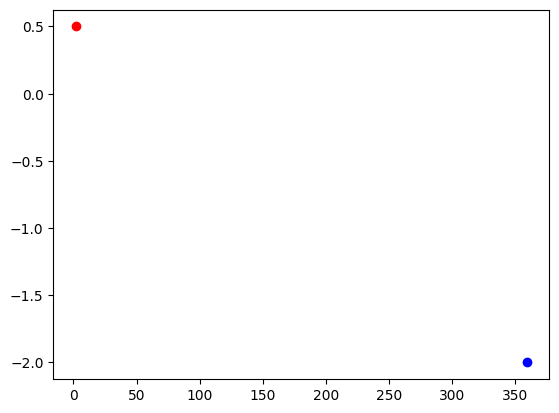

In [5]:
plt.scatter(gbtd_fov.l.value[0], gbtd_fov.b.value[0], c="blue")
plt.scatter(gbtd_fov.l.value[-1], gbtd_fov.b.value[-1], c="red")

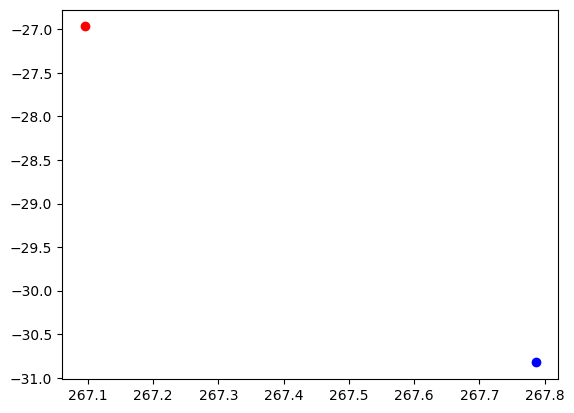

In [6]:
plt.scatter(gbtd_fov.transform_to("icrs").ra.value[0], gbtd_fov.transform_to("icrs").dec.value[0], c="blue")
plt.scatter(gbtd_fov.transform_to("icrs").ra.value[-1], gbtd_fov.transform_to("icrs").dec.value[-1], c="red")

In [96]:
gbtd_time_season[-1] - gbtd_time_season[0]

<TimeDelta object: scale='tai' format='jd' value=60.46597222222222>

In [137]:
all_days = []

for day in tqdm(gbtd_time_season, total=len(gbtd_time_season), desc="Qerying day"):

    catalog = query_jpl_sbi(
        edge1=gbtd_fov.transform_to("icrs")[0],
        edge2=gbtd_fov.transform_to("icrs")[-1],
        obstime=day,
        maglim=28,
        elem=False,
        sb_kind="all",
        spice=True,
    )
    elem = query_jpl_sbi(
        edge1=gbtd_fov.transform_to("icrs")[0],
        edge2=gbtd_fov.transform_to("icrs")[-1],
        obstime=day,
        maglim=28,
        elem=True,
        sb_kind="all",
        spice=True,
    )
    all_days.append(pd.merge(catalog, elem, how="outer", on="Object name"))

all_days = pd.concat(all_days, axis=0).drop_duplicates(subset=["Object name"]).reset_index(drop=True)
all_days["H_mag"] = all_days["H_mag"].astype(float)

Qerying day:   0%|                                                                                        | 0/35 [00:00<?, ?it/s]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:   3%|██▏                                                                          | 1/35 [03:35<2:01:50, 215.02s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:   6%|████▍                                                                        | 2/35 [07:10<1:58:15, 215.01s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:   9%|██████▌                                                                      | 3/35 [10:41<1:53:41, 213.18s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  11%|████████▊                                                                    | 4/35 [14:12<1:49:42, 212.34s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  14%|███████████                                                                  | 5/35 [17:49<1:47:09, 214.32s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  17%|█████████████▏                                                               | 6/35 [21:21<1:43:08, 213.40s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  20%|███████████████▍                                                             | 7/35 [24:57<1:39:58, 214.24s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  23%|█████████████████▌                                                           | 8/35 [28:29<1:36:04, 213.49s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  26%|███████████████████▊                                                         | 9/35 [32:48<1:38:43, 227.84s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  29%|█████████████████████▋                                                      | 10/35 [36:51<1:36:48, 232.34s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  31%|███████████████████████▉                                                    | 11/35 [43:01<1:49:46, 274.46s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  34%|██████████████████████████                                                  | 12/35 [46:38<1:38:36, 257.24s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  37%|████████████████████████████▏                                               | 13/35 [49:55<1:27:35, 238.87s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  40%|██████████████████████████████▍                                             | 14/35 [53:12<1:19:08, 226.10s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  43%|████████████████████████████████▌                                           | 15/35 [56:29<1:12:26, 217.33s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  46%|██████████████████████████████████▋                                         | 16/35 [59:43<1:06:34, 210.26s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  49%|███████████████████████████████████▉                                      | 17/35 [1:02:54<1:01:22, 204.60s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  51%|███████████████████████████████████████                                     | 18/35 [1:06:09<57:11, 201.84s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  54%|█████████████████████████████████████████▎                                  | 19/35 [1:09:22<53:03, 198.99s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  57%|███████████████████████████████████████████▍                                | 20/35 [1:12:28<48:49, 195.30s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  60%|█████████████████████████████████████████████▌                              | 21/35 [1:15:33<44:49, 192.12s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  63%|███████████████████████████████████████████████▊                            | 22/35 [1:18:37<41:06, 189.73s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  66%|█████████████████████████████████████████████████▉                          | 23/35 [1:21:39<37:28, 187.34s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  69%|████████████████████████████████████████████████████                        | 24/35 [1:24:41<34:02, 185.64s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  71%|██████████████████████████████████████████████████████▎                     | 25/35 [1:27:40<30:36, 183.64s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  74%|████████████████████████████████████████████████████████▍                   | 26/35 [1:31:09<28:42, 191.36s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  77%|██████████████████████████████████████████████████████████▋                 | 27/35 [1:34:31<25:57, 194.64s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  80%|████████████████████████████████████████████████████████████▊               | 28/35 [1:37:49<22:47, 195.42s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  83%|██████████████████████████████████████████████████████████████▉             | 29/35 [1:41:43<20:43, 207.24s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  86%|█████████████████████████████████████████████████████████████████▏          | 30/35 [1:44:46<16:39, 199.86s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  89%|███████████████████████████████████████████████████████████████████▎        | 31/35 [1:47:36<12:43, 190.85s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  91%|█████████████████████████████████████████████████████████████████████▍      | 32/35 [1:50:22<09:10, 183.48s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  94%|███████████████████████████████████████████████████████████████████████▋    | 33/35 [1:53:09<05:56, 178.43s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day:  97%|█████████████████████████████████████████████████████████████████████████▊  | 34/35 [1:55:58<02:55, 175.71s/it]

Requesting JPL Smal-bodies API
Requesting JPL Smal-bodies API


Qerying day: 100%|████████████████████████████████████████████████████████████████████████████| 35/35 [1:58:44<00:00, 203.56s/it]


In [138]:
all_days.to_csv("../data/catalogs/horizon_visbile_asteroids_GB_seasson1_from_JWST.csv")

In [155]:
all_days.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8162 entries, 0 to 8161
Data columns (total 26 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Object name                        8162 non-null   object 
 1   Astrometric RA (hh:mm:ss)          8162 non-null   object 
 2   Astrometric Dec (dd mm'ss")        8162 non-null   object 
 3   Dist. from center RA (")           8162 non-null   object 
 4   Dist. from center Dec (")          8162 non-null   object 
 5   Dist. from center Norm (")         8162 non-null   object 
 6   Visual magnitude (V)               8162 non-null   object 
 7   RA rate ("/h)                      8162 non-null   float64
 8   Dec rate ("/h)                     8162 non-null   float64
 9   ra                                 8162 non-null   float64
 10  dec                                8162 non-null   float64
 11  V_mag                              8162 non-null   float

In [156]:
all_days["rate"] = np.hypot(all_days['RA rate ("/h)'], all_days['Dec rate ("/h)'])

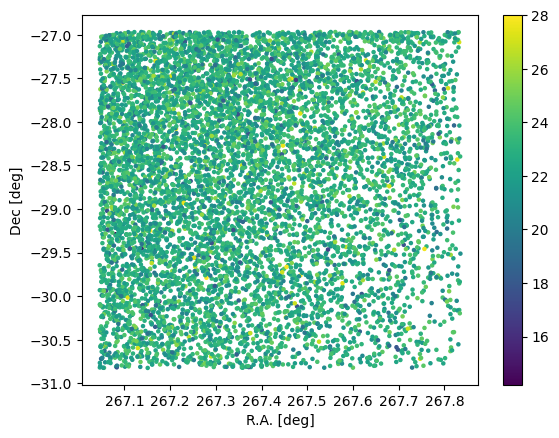

In [139]:
bar = plt.scatter(all_days.ra, all_days.dec, c=all_days.V_mag, s=5)
plt.colorbar(bar)
plt.xlabel("R.A. [deg]")
plt.ylabel("Dec [deg]")
plt.show()

In [250]:
all_days["semimajor_axis (au)"] = all_days["Perihelion (au)"]/(1 - all_days["Eccentricity"])

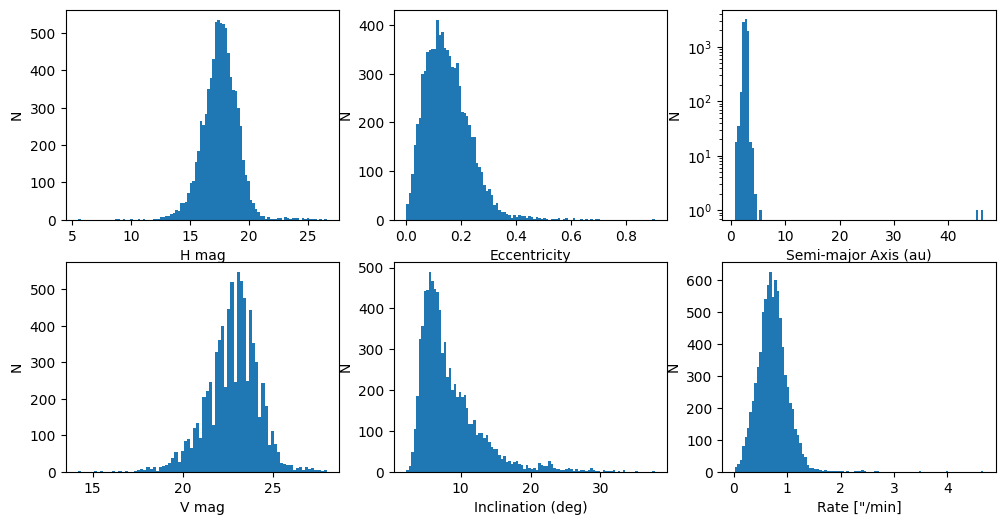

In [251]:
fig, ax = plt.subplots(2, 3, figsize=(12,6))

ax[0, 0].hist(all_days["H_mag"].values, bins=100)
ax[0, 0].set_xlabel("H mag")
ax[0, 0].set_ylabel("N")

ax[0, 1].hist(all_days["Eccentricity"].values, bins=100)
ax[0, 1].set_xlabel("Eccentricity")
ax[0, 1].set_ylabel("N")

ax[0, 2].hist(all_days["semimajor_axis (au)"].values, bins=100, log=True)
ax[0, 2].set_xlabel("Semi-major Axis (au)")
ax[0, 2].set_ylabel("N")

ax[1, 0].hist(all_days["V_mag"].values, bins=80)
ax[1, 0].set_xlabel("V mag")
ax[1, 0].set_ylabel("N")

ax[1, 1].hist(all_days["Inclination (deg)"].values, bins=100)
ax[1, 1].set_xlabel("Inclination (deg)")
ax[1, 1].set_ylabel("N")

ax[1, 2].hist(all_days["rate"].values / 60, bins=100)
ax[1, 2].set_xlabel('Rate ["/min]')
ax[1, 2].set_ylabel("N")

plt.show()

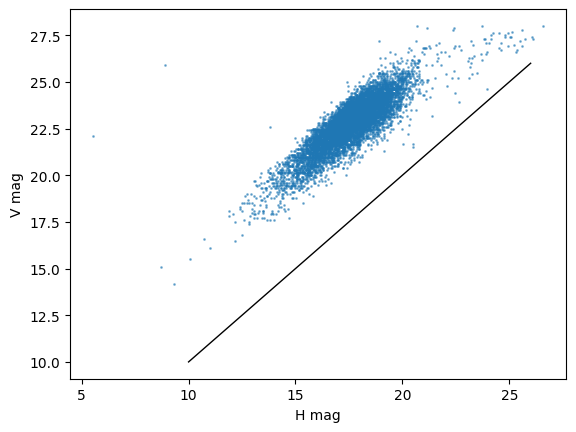

In [315]:
plt.scatter(all_days["H_mag"], all_days["V_mag"], s=1, alpha=0.5);
plt.plot([10, 26], [10, 26], c="k", lw=1)
plt.xlabel("H mag")
plt.ylabel("V mag")
plt.show()

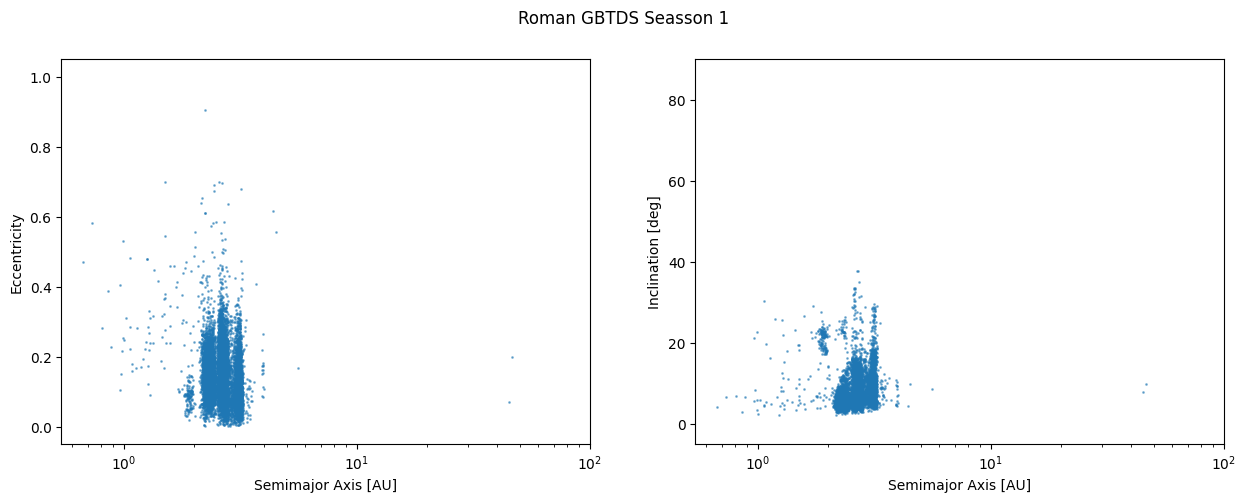

In [276]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle("Roman GBTDS Seasson 1")

cbar = ax[0].scatter(all_days["semimajor_axis (au)"].values,
                     all_days["Eccentricity"].values,
                     # c=all_days.H_mag.values,
                     vmin=0, vmax=27, s=1, alpha=0.5)
# plt.colorbar(cbar, ax=ax[0], label="H mag")
ax[0].set_xscale("log")
ax[0].set_xlabel("Semimajor Axis [AU]")
ax[0].set_ylabel("Eccentricity")
ax[0].set_xlim(0, 100)
ax[0].set_ylim(-0.05, 1.05)

cbar = ax[1].scatter(all_days["semimajor_axis (au)"].values,
                     all_days["Inclination (deg)"].values,
                     # c=all_days.H_mag.values,
                     vmin=0, vmax=27, s=1, alpha=0.5)
# plt.colorbar(cbar, ax=ax, label="H mag", location="bottom", shrink=0.5)
ax[1].set_xscale("log")
ax[1].set_xlabel("Semimajor Axis [AU]")
ax[1].set_ylabel("Inclination [deg]")
ax[1].set_xlim(0, 100)
ax[1].set_ylim(-5, 90)

plt.show()

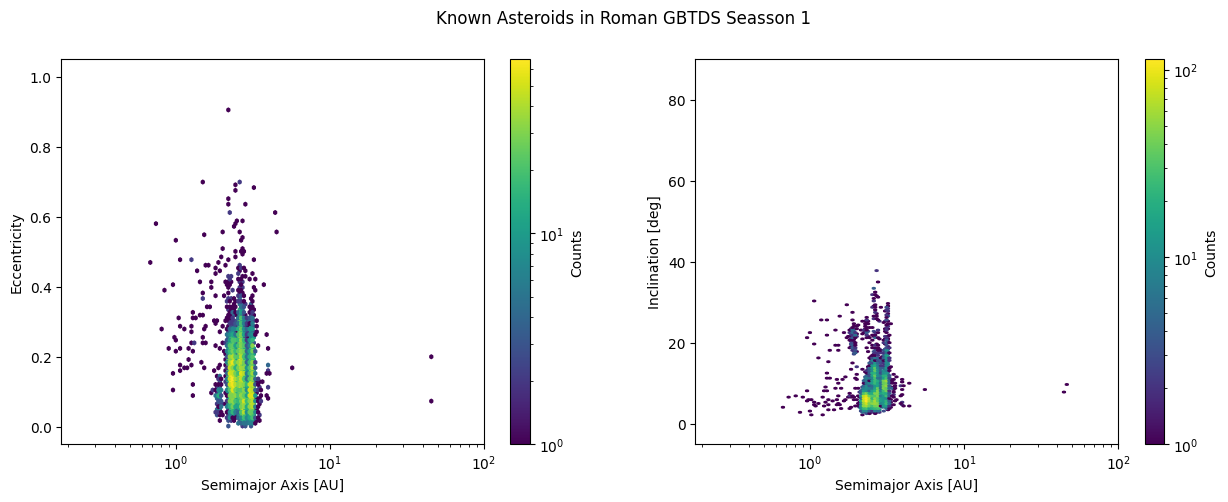

In [304]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle("Known Asteroids in Roman GBTDS Seasson 1")

cbar = ax[0].hexbin(all_days["semimajor_axis (au)"].values,
                    all_days["Eccentricity"].values,
                    gridsize=100,
                    xscale="log",
                    cmap="viridis",
                    bins='log')
                    
plt.colorbar(cbar, ax=ax[0], label="Counts", location="right")
ax[0].set_xlabel("Semimajor Axis [AU]")
ax[0].set_ylabel("Eccentricity")
ax[0].set_xlim(0.18, 100)
ax[0].set_ylim(-0.05, 1.05)

cbar = ax[1].hexbin(all_days["semimajor_axis (au)"].values,
                    all_days["Inclination (deg)"].values,
                    gridsize=100,
                    xscale="log",
                    cmap="viridis",
                    bins='log')
                    
plt.colorbar(cbar, ax=ax[1], label="Counts", location="right")
ax[1].set_xlabel("Semimajor Axis [AU]")
ax[1].set_ylabel("Inclination [deg]")
ax[1].set_xlim(0.18, 100)
ax[1].set_ylim(-5, 90)

plt.show()

# MPC obr catalog

MPC orbit catalog statistics
Table columns are described here:
https://www.minorplanetcenter.net/iau/info/MPOrbitFormat.html

Also can be reteived from Rubin Sci plataform that has quick ADQL access to MPCORB tables  https://dp0-3.lsst.io/v/PREOPS-5231/tutorials-dp0-3/portal-dp0-3-3.html

In [162]:
from astroquery.mpc import MPC

In [239]:
ast_result = MPC.query_objects('asteroid', semimajor_axis_min=0.1, semimajor_axis_max=1000, limit=15000)
ast = pd.DataFrame.from_dict(ast_result)

In [240]:
ast.shape

(15000, 49)

In [242]:
mpcorb = pd.read_csv("../data/catalogs/table_dp03_catalogs_10yr.MPCORB-data-1.csv")
mpcorb

,e,incl,q,mpcH,mpcDesignation,a
0,0.951177,11.664650,65.071390,5.570,2015 TG387,1332.791473
1,0.265521,27.263026,45.757914,7.680,SS00019fa,62.299787
2,0.049554,7.354480,45.233507,5.310,STC002cGa,47.591852
3,0.046982,28.165130,45.209921,8.000,2016 LD89,47.438698
4,0.054889,3.474740,44.567971,7.360,STC006Iaa,47.156337
...,...,...,...,...,...,...
174865,0.995939,67.457563,0.010028,24.859,S000123Ya,2.469553
174866,0.996198,44.445649,0.008754,24.286,S0000Eooa,2.302575
174867,0.995960,55.584816,0.007392,24.516,S0000MBCa,1.829897
174868,0.999108,16.192065,0.002159,24.822,S00010e1a,2.421579


In [264]:
mpcorb_plot = mpcorb.query("a > 0 and a <= 100 and e >= 0 and e <= 1 and incl >=0 and incl <=90")
mpcorb_plot.shape

(174713, 6)

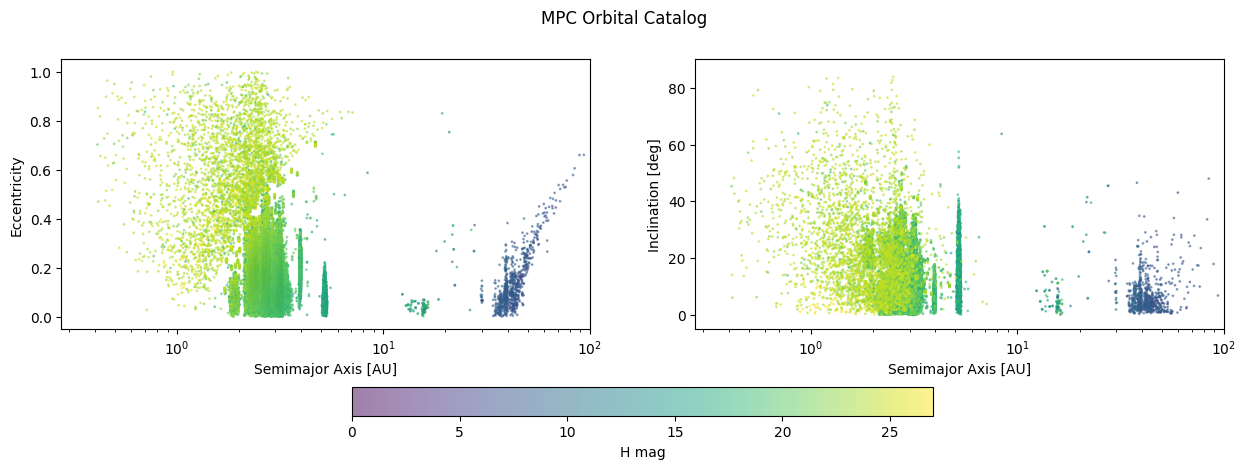

In [261]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle("MPC Orbital Catalog")

cbar = ax[0].scatter(mpcorb.a.values,
                     mpcorb.e.values,
                     c=mpcorb.mpcH.values,
                     vmin=0, vmax=27, s=1, alpha=0.5)
# plt.colorbar(cbar, ax=ax[0], label="H mag")
ax[0].set_xscale("log")
ax[0].set_xlabel("Semimajor Axis [AU]")
ax[0].set_ylabel("Eccentricity")
ax[0].set_xlim(0, 100)
ax[0].set_ylim(-0.05, 1.05)

cbar = ax[1].scatter(mpcorb.a.values,
                     mpcorb.incl.values,
                     c=mpcorb.mpcH.values,
                     vmin=0, vmax=27, s=1, alpha=0.5)
plt.colorbar(cbar, ax=ax, label="H mag", location="bottom", shrink=0.5)
ax[1].set_xscale("log")
ax[1].set_xlabel("Semimajor Axis [AU]")
ax[1].set_ylabel("Inclination [deg]")
ax[1].set_xlim(0, 100)
ax[1].set_ylim(-5, 90)

plt.show()

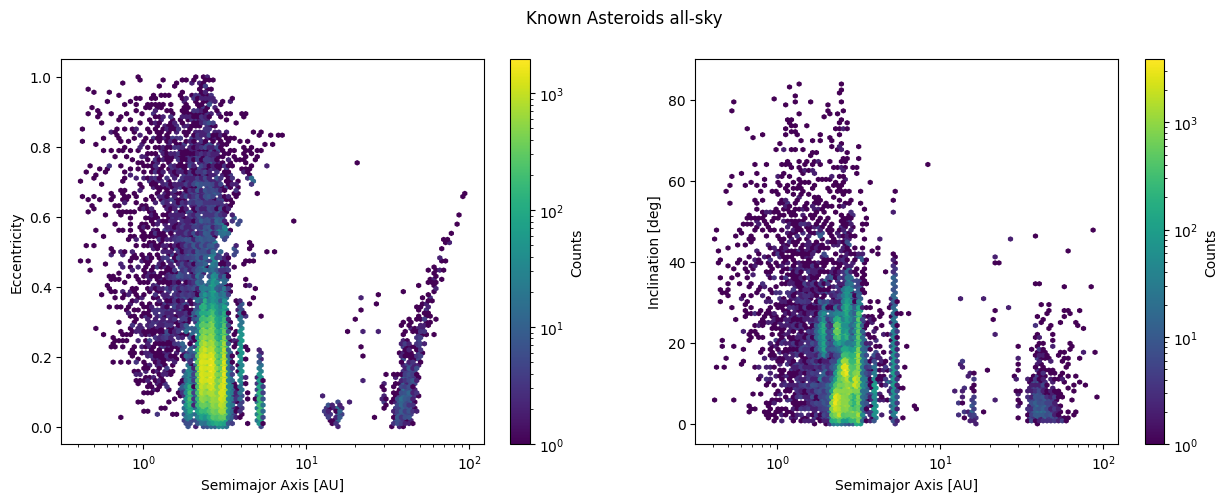

In [305]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle("Known Asteroids all-sky")

cbar = ax[0].hexbin(mpcorb_plot.a.values,
                    mpcorb_plot.e.values,
                    gridsize=100,
                    xscale="log",
                    cmap="viridis",
                    bins='log')
plt.colorbar(cbar, ax=ax[0], label="Counts", location="right")

ax[0].set_xlabel("Semimajor Axis [AU]")
ax[0].set_ylabel("Eccentricity")
# ax[0].set_xlim(0, 100)
ax[0].set_ylim(-0.05, 1.05)

cbar = ax[1].hexbin(mpcorb_plot.a.values,
                    mpcorb_plot.incl.values,
                    gridsize=100,
                    xscale="log",
                    cmap="viridis",
                    bins="log")
plt.colorbar(cbar, ax=ax[1], label="Counts", location="right")

ax[1].set_xlabel("Semimajor Axis [AU]")
ax[1].set_ylabel("Inclination [deg]")
# ax[1].set_xlim(0, 100)
ax[1].set_ylim(-5, 90)

plt.show()

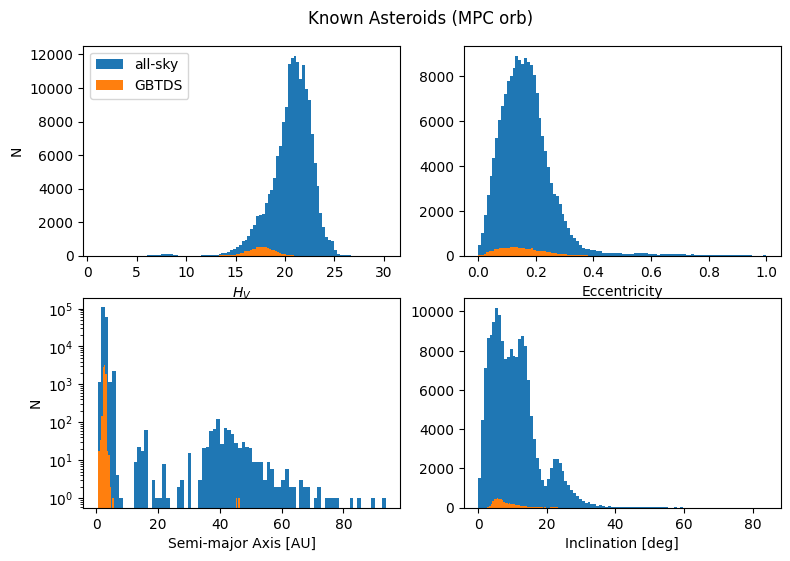

In [303]:
fig, ax = plt.subplots(2, 2, figsize=(9,6))
fig.suptitle("Known Asteroids (MPC orb)", y=0.94)

ax[0, 0].hist(mpcorb_plot["mpcH"].values, bins=100, label="all-sky")
ax[0, 0].hist(all_days["H_mag"].values, bins=100, label="GBTDS")
ax[0, 0].set_xlabel("$H_{V}$")
ax[0, 0].set_ylabel("N")
ax[0, 0].legend()

ax[0, 1].hist(mpcorb_plot["e"].values, bins=100)
ax[0, 1].hist(all_days["Eccentricity"].values, bins=100)
ax[0, 1].set_xlabel("Eccentricity")

ax[1, 0].hist(mpcorb_plot["a"].values, bins=80, log=True)
ax[1, 0].hist(all_days["semimajor_axis (au)"].values, bins=100, log=True)
ax[1, 0].set_xlabel("Semi-major Axis [AU]")
ax[1, 0].set_ylabel("N")
# ax[1, 0].set_xscale("log")

ax[1, 1].hist(mpcorb_plot["incl"].values, bins=100)
ax[1, 1].hist(all_days["Inclination (deg)"].values, bins=100)
ax[1, 1].set_xlabel("Inclination [deg]")

plt.show()